In [ ]:
# we used Google Colab to run all experiments so we 
# first set up connection to Google Drive

from google.colab import drive
drive.mount('/content/drive')

import sys
import os

py_file_location = "/content/drive/MyDrive/dlg-master"
sys.path.append(os.path.abspath(py_file_location))

Mounted at /content/drive


In [ ]:
# change to directory containing DLG source files
%cd "/content/drive/MyDrive/dlg-master"

# import relevant packages
import argparse
import numpy as np
from pprint import pprint

from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
import torchvision
from torchvision import models, datasets, transforms
print(torch.__version__, torchvision.__version__)

from utils import label_to_onehot, cross_entropy_for_onehot

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
print("Running on %s" % device)

/content/drive/MyDrive/dlg-master
1.11.0+cu113 0.12.0+cu113
Running on cuda


In [ ]:
# pick random training image indices for CIFAR-100 data set
import random
random.seed(2022)
print(random.sample(range(0, 50000), 20))

[34840, 18934, 29006, 35766, 20319, 38395, 3983, 33958, 45321, 46222, 27024, 44895, 41552, 20529, 803, 49872, 28271, 20224, 42349, 40975]


  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting /root/.torch/cifar-100-python.tar.gz to /root/.torch


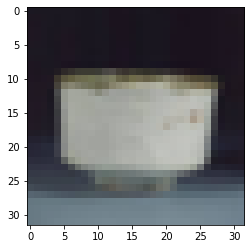

In [ ]:
# download CIFAR-100 data set
dst = datasets.CIFAR100("~/.torch", download=True)
tp = transforms.ToTensor()
tt = transforms.ToPILImage()

# get ground truth image and label
img_index = 20319
gt_data = tp(dst[img_index][0]).to(device)
gt_data = gt_data.view(1, *gt_data.size())
gt_label = torch.Tensor([dst[img_index][1]]).long().to(device)
gt_label = gt_label.view(1, )
gt_onehot_label = label_to_onehot(gt_label)

# show ground truth image
plt.imshow(tt(gt_data[0].cpu()))


 ==================== Working on seed 0: 1495 ====================

current method: DLG

0 64.7159652709960938
10 0.9712580442428589
20 0.0811603218317032
30 0.0155995674431324
40 0.0040509286336601
50 0.0012650593416765
60 0.0004960525548086
70 0.0002014729543589
80 0.0000823654263513
90 0.0000356218297384


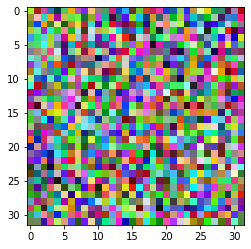

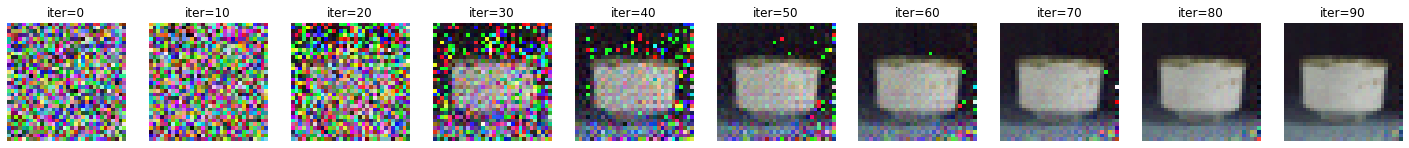


 ==================== Working on seed 9: 1495 ====================

current method: iDLG

0 43.5318260192871094
10 0.7460653185844421
20 0.0615884847939014
30 0.0108821019530296
40 0.0025795502588153
50 0.0008005974814296
60 0.0003043884644285
70 0.0001263563608518
80 0.0000584579902352
90 0.0000234390263358


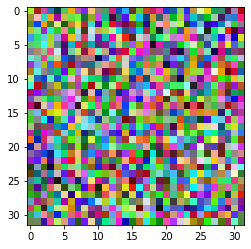

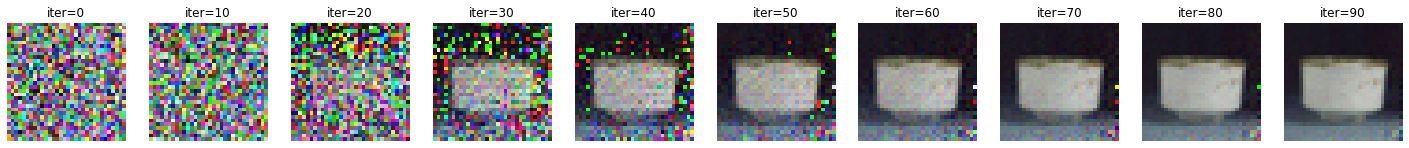

In [ ]:
# this cell is for experiments with LeNet

from models.vision import LeNet, weights_init
net = LeNet().to(device) # LeNet
random.seed(1234)

# select random seeds to run DLG and iDLG
num_seeds = 50
seeds = random.sample(range(0, 10000), num_seeds)

num_iter = 100
conv_yes = np.zeros(num_seeds)
conv_iter = num_iter*np.ones(num_seeds)

# convergence criterion is set to be when loss is less than 0.0001
conv_crit = 0.0001

# loop over all seeds
for i in range(num_seeds):

    loss_DLG_lenet = []
    loss_iDLG_lenet = []
    mse_DLG_lenet = []
    mse_iDLG_lenet = []

    # for each seed, try both DLG and iDLG
    for method in ['DLG', 'iDLG']:

        seed = seeds[i]

        print("\n ==================== Working on seed {}: {} ====================\n".format(i, seed))

        torch.manual_seed(seed)

        print('current method: {}\n'.format(method))

        net.apply(weights_init) 
        criterion = cross_entropy_for_onehot

        # compute original gradient 
        pred = net(gt_data)
        y = criterion(pred, gt_onehot_label)
        dy_dx = torch.autograd.grad(y, net.parameters())

        original_dy_dx = list((_.detach().clone() for _ in dy_dx))

        # generate dummy data and label
        dummy_data = torch.randn(gt_data.size()).to(device).requires_grad_(True)
        dummy_label = torch.randn(gt_onehot_label.size()).to(device).requires_grad_(True)

        plt.imshow(tt(dummy_data[0].cpu()))

        if method == 'DLG':
            optimizer = torch.optim.LBFGS([dummy_data, dummy_label])
        elif method == 'iDLG':
            optimizer = torch.optim.LBFGS([dummy_data, ])
            # predict the ground-truth label
            label_pred = torch.argmin(torch.sum(original_dy_dx[-2], dim=-1), dim=-1).detach().reshape((1,)).requires_grad_(False)
            label_pred_onehot = label_to_onehot(label_pred)

        history = []
        history_all = []

        losses = []
        mses = []

        # DLG/iDLG algorithm
        for iters in range(num_iter):
            def closure():
                optimizer.zero_grad()

                dummy_pred = net(dummy_data) 

                if method == 'DLG':
                    dummy_onehot_label = F.softmax(dummy_label, dim=-1)
                    dummy_loss = criterion(dummy_pred, dummy_onehot_label) 
                elif method == 'iDLG':
                    dummy_loss = criterion(dummy_pred, label_pred_onehot)

                dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)
                
                grad_diff = 0
                for gx, gy in zip(dummy_dy_dx, original_dy_dx): 
                    grad_diff += ((gx - gy) ** 2).sum()
                grad_diff.backward()
                
                return grad_diff
            
            optimizer.step(closure)

            current_loss = closure().item()
            history_all.append(tt(dummy_data[0].cpu()))

            losses.append(current_loss)
            mses.append(torch.mean((dummy_data-gt_data)**2).item())

            if method == 'DLG':
                loss_DLG_lenet = losses
                mse_DLG_lenet = mses
            elif method == 'iDLG':
                loss_iDLG_lenet = losses
                mse_iDLG_lenet = mses

            if current_loss < conv_crit:
                conv_yes[i] = 1
                conv_iter[i] = iters
                break

            if iters % 10 == 0: 
                print(iters, "%.16f" % current_loss)
                history.append(tt(dummy_data[0].cpu()))


        plt.figure(figsize=(25, 40))
        for i in range(len(history_all)//10):
            plt.subplot(iters//10, 10, i + 1)
            plt.imshow(history[i])
            plt.title("iter=%d" % (i * 10))
            plt.axis('off')

        plt.show()

In [ ]:
# this cell is for computing summary statistics, i.e., success rate 
# and average number of iterations at convergence for LeNet

# note that this is only done for LeNet, since ResNet-18 does not give 
# meaningful training image reconstructions

conv_count = sum(conv_yes)
conv_iter_pure = []
for k in range(num_seeds):
    if conv_yes[k]:
        conv_iter_pure.append(conv_iter[k])


print("DLG success rate: {}%".format(conv_count/num_seeds*100))
print("Mean iter number at convergence: {}".format(np.mean(conv_iter_pure)))

DLG success rate: 0.0%
Mean iter number at convergence: nan


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



 ==================== Working on seed 0: 1495 ====================

current method: DLG



/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0 0.7094917893409729
10 0.0000230181649385
20 0.0000010733839417
30 0.0000004979805794
40 0.0000004188989351
50 0.0000003863308962
60 0.0000003700334048
70 0.0000003468034038
80 0.0000003420118730
90 0.0000003420118730


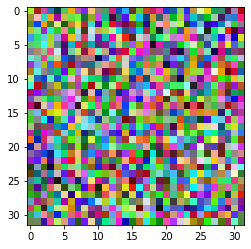

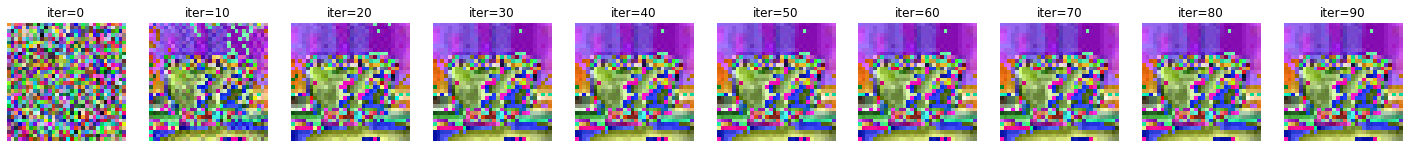


 ==================== Working on seed 9: 1495 ====================

current method: iDLG

0 0.5957861542701721
10 0.0000176571338670
20 0.0000007762139944
30 0.0000003905301185
40 0.0000003431684092
50 0.0000003178233214
60 0.0000003056256332
70 0.0000002942541926
80 0.0000002926722686
90 0.0000002926722686


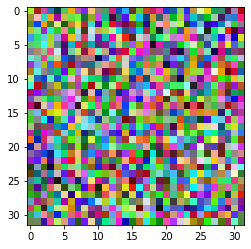

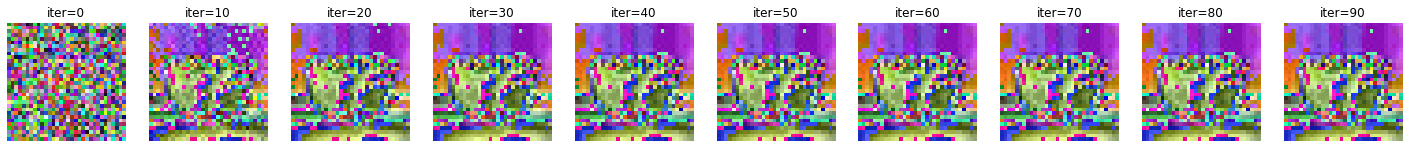

In [ ]:
# this cell is for experiments with ResNet-18

from models.vision import resnet_weights_init, ResNet18
net = ResNet18().to(device) # ResNet-18
random.seed(1234)

# select random seeds to run DLG and iDLG
num_seeds = 20
seeds = random.sample(range(0, 10000), num_seeds)

num_iter = 100
conv_yes = np.zeros(num_seeds)
conv_iter = num_iter*np.ones(num_seeds)

# loop over all seeds
for i in range(num_seeds):

    loss_DLG_resnet = []
    loss_iDLG_resnet = []
    mse_DLG_resnet = []
    mse_iDLG_resnet = []

    # for each seed, try both DLG and iDLG
    for method in ['DLG', 'iDLG']:

        seed = seeds[i] 

        print("\n ==================== Working on seed {}: {} ====================\n".format(i, seed))

        torch.manual_seed(seed)

        print('current method: {}\n'.format(method))

        net.apply(resnet_weights_init) 
        criterion = cross_entropy_for_onehot

        # compute original gradient 
        pred = net(gt_data)
        y = criterion(pred, gt_onehot_label)
        dy_dx = torch.autograd.grad(y, net.parameters())

        original_dy_dx = list((_.detach().clone() for _ in dy_dx))

        # generate dummy data and label
        dummy_data = torch.randn(gt_data.size()).to(device).requires_grad_(True)
        dummy_label = torch.randn(gt_onehot_label.size()).to(device).requires_grad_(True)

        plt.imshow(tt(dummy_data[0].cpu()))

        if method == 'DLG':
            optimizer = torch.optim.LBFGS([dummy_data, dummy_label])
        elif method == 'iDLG':
            optimizer = torch.optim.LBFGS([dummy_data, ])
            # predict the ground-truth label
            label_pred = torch.argmin(torch.sum(original_dy_dx[-2], dim=-1), dim=-1).detach().reshape((1,)).requires_grad_(False)
            label_pred_onehot = label_to_onehot(label_pred)

        history = []
        history_all = []

        losses = []
        mses = []

        # DLG/iDLG algorithm
        for iters in range(num_iter):
            def closure():
                optimizer.zero_grad()

                dummy_pred = net(dummy_data) 

                if method == 'DLG':
                    dummy_onehot_label = F.softmax(dummy_label, dim=-1)
                    dummy_loss = criterion(dummy_pred, dummy_onehot_label) 
                elif method == 'iDLG':
                    dummy_loss = criterion(dummy_pred, label_pred_onehot)

                dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)
                
                grad_diff = 0
                for gx, gy in zip(dummy_dy_dx, original_dy_dx): 
                    grad_diff += ((gx - gy) ** 2).sum()
                grad_diff.backward()
                
                return grad_diff
            
            optimizer.step(closure)

            current_loss = closure().item()
            history_all.append(tt(dummy_data[0].cpu()))

            losses.append(current_loss)
            mses.append(torch.mean((dummy_data-gt_data)**2).item())

            if method == 'DLG':
                loss_DLG_resnet = losses
                mse_DLG_resnet = mses
            elif method == 'iDLG':
                loss_iDLG_resnet = losses
                mse_iDLG_resnet = mses

            if iters % 10 == 0: 
                print(iters, "%.16f" % current_loss)
                history.append(tt(dummy_data[0].cpu()))


        plt.figure(figsize=(25, 40))
        for i in range(len(history_all)//10):
            plt.subplot(iters//10, 10, i + 1)
            plt.imshow(history[i])
            plt.title("iter=%d" % (i * 10))
            plt.axis('off')

        plt.show()

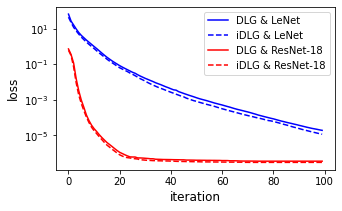

In [ ]:
# generate convergence plot for loss

plt.figure(figsize=(5, 3))
plt.semilogy(range(100), loss_DLG_lenet, 'b-', label='DLG & LeNet')
plt.semilogy(range(100), loss_iDLG_lenet, 'b--', label='iDLG & LeNet')
plt.semilogy(range(100), loss_DLG_resnet, 'r-', label='DLG & ResNet-18')
plt.semilogy(range(100), loss_iDLG_resnet, 'r--', label='iDLG & ResNet-18')
plt.xlabel('iteration', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.legend()

<Figure size 432x288 with 0 Axes>

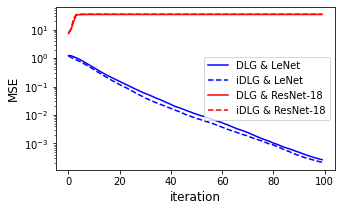

In [ ]:
# generate convergence plot for MSE

plt.clf()

plt.figure(figsize=(5, 3))
plt.semilogy(range(100), mse_DLG_lenet, 'b-', label='DLG & LeNet')
plt.semilogy(range(100), mse_iDLG_lenet, 'b--', label='iDLG & LeNet')
plt.semilogy(range(100), mse_DLG_resnet, 'r-', label='DLG & ResNet-18')
plt.semilogy(range(100), mse_iDLG_resnet, 'r--', label='iDLG & ResNet-18')
plt.xlabel('iteration', fontsize=12)
plt.ylabel('MSE', fontsize=12)
plt.legend()